# MTH3302 : Méthodes probabilistes et statistiques pour l'I.A.

Jonathan Jalbert<br/>
Professeur agrégé au Département de mathématiques et de génie industriel<br/>
Polytechnique Montréal<br/>


# TD2 - Régression linéaire

Ce TD concerne la régression linéaire (Chapitre 2 du cours). À la fin de ce TD, vous devriez être avoir été en mesure de :
- Estimer les coefficients des paramètres de la régression linéaire simple avec la méthode des moindres carrés.
- Estimer les coefficients des paramètres de la régression linéaire multiple avec la méthode des moindres carrés.
- Calculer le coefficient de détermination.
- Sélectionner le meilleur modèle unidimensionnel.
- Calculer avec des méthodes numériquement stables les coefficients de régression.

# Contexte : Pourcentage de matière grasse

Le pourcentage de matière grasse d'un patient est une mesure largement utilisée en médecine pour estimer les facteurs de risque de plusieurs maladies. Cette quantité est cependant très difficile à mesurer. La mesure implique en effet d’immerger le patient dans un cylindre gradué rempli d’eau afin de calculer sa masse volumique. Cette procédure est non seulement inconfortable pour le patient mais pratiquement impossible à effectuer dans le bureau du médecin.

Par conséquent, on souhaite savoir si on peut prédire le pourcentage de gras Y avec trois mesures beaucoup plus simples à obtenir :

- $x_1$ : l'épaisseur des plis de la peau des triceps (en mm) ;<br/>
- $x_2$ : le tour de cuisse (en mm) ;<br/>
- $x_3$ : la circonférence du bras en (mm).<br/>

Les mesures du fichier *bodyfat.csv* proviennent de 20 femmes en bonne santé, âgées entre 20 et 34 ans. Ceci est un jeu de données réel.


In [1]:
# Chargement des librairies
using CSV, DataFrames, Distributions, Gadfly, Statistics, LinearAlgebra

# Exercice 1 - Régression linéaire simple

Nous étudierons dans cet exercice la meilleure variable explicative pour le pourcentage de matière grasse.

In [2]:
# Chargement des données
data = CSV.read("bodyfat.csv", DataFrame)
first(data,5)

,Triceps,Thigh,Midarm,Bodyfat
,Float64,Float64,Float64,Float64
1,19.5,43.1,29.1,11.9
2,24.7,49.8,28.2,22.8
3,30.7,51.9,37.0,18.7
4,29.8,54.3,31.1,20.1
5,19.1,42.2,30.9,12.9


In [24]:
triceps = data[:, :Triceps]
thigh = data[:, :Thigh]
midarm = data[:, :Midarm]
bodyfat = data[:, :Bodyfat]
n = length(bodyfat)

20

## a) Affichage du pourcentage de graisse en fonction des variables explicatives

Tracer les nuages de points du pourcentage de graisse en fonction des variables explicatives. 

- Est-ce qu'une relation linéaire semble appropriée pour chacune de ces trois variables ? 
- Quelle variable vous semble la meilleure et pour quelle raison ?

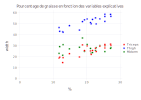

In [22]:
plot(data, 
    layer(y=:Triceps, x=:Bodyfat, Theme(default_color="red")),
    layer(y=:Thigh, x=:Bodyfat, Theme(default_color="blue")),
    layer(y=:Midarm, x=:Bodyfat, Theme(default_color="green")),
    Guide.xlabel("%"), Guide.ylabel("width"), Guide.title("Pourcentage de graisse en fonction des variables explicatives"),
    Guide.manual_color_key("",["Triceps","Thigh", "Midarm"],
                            ["red","blue","green"])
)

## b) Estimation des paramètres de la régression linéaire simple avec $x₁$

Estimez lez paramètres du modèle de régression linéaire pour chacun des trois variables explicatives.

In [55]:
ȳ = mean(bodyfat)
y = bodyfat
betas = []
for a in [[triceps, "Triceps"], [thigh, "Thigh"], [midarm, "Midarm"]]
    println("## Variable ", a[2])
    x = a[1]
    x̄ = mean(x)


    # Estimation des paramètres
    β̂₁ = sum((x[i] - x̄)*(bodyfat[i] - ȳ) for i=1:n) / sum( (x[i] - x̄)^2 for i=1:n )

    β̂₀ = ȳ - β̂₁*x̄

    println("β̂₀=", β̂₀)
    println("β̂₁=", β̂₁)
    println()
    
    push!(betas,[β̂₀,β̂₁, a[1], a[2]])

end

## Variable Triceps
β̂₀=-1.4961046410368972
β̂₁=0.8571865102168306

## Variable Thigh
β̂₀=-23.634489130309518
β̂₁=0.85654659234531

## Variable Midarm
β̂₀=14.686780858775304
β̂₁=0.1994286437807638



In [ ]:
# Vous devriez obtenir β̂₀ = -1.50 et β̂₁ = 0.857.

## c) Affichage de la droite de régression obtenue

Superposez au nuage de points précédent la droite de régression estimée. Vous pouvez utiliser la géométrie `Geom.abline()` de *Gadfly*. 

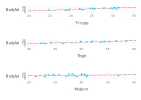

In [71]:
figs = []
for beta in betas
    push!(figs, plot(data, x=beta[3], y=:Bodyfat, Geom.point, 
    intercept = [beta[1]], slope = [beta[2]], Geom.abline(color="red", style=:dash),
    Guide.xlabel(beta[4]),
    Guide.ylabel("Bodyfat")))
end

vstack(figs[1], figs[2], figs[3]) 

## d) Calcul du coefficient de détermination

Calculez le coefficient de détermination de la régression.

In [68]:
ȳ = mean(bodyfat)
y = bodyfat
for a in [[triceps, "Triceps"], [thigh, "Thigh"], [midarm, "Midarm"]]
    # Construction de la matrice de structure (Notez la colonnes de 1)
    X = hcat(ones(n),a[1])

    # Estimation des paramètres du modèle de régression
    β̂ = (X'X)\X'y

    
    ȳ = mean(y)
    
    ŷ = X*β̂

    e = y-ŷ

    SST = sum( (y .- ȳ).^2 )
    SSR = sum( (ŷ .- ȳ).^2 )
    SSE = sum(e.^2)

    R² = SSR/SST
    println("Le coefficient de détermination est de ", R², " pour ", a[2])
end



Le coefficient de détermination est de 0.7110966155559758 pour Triceps
Le coefficient de détermination est de 0.7710414083276425 pour Thigh
Le coefficient de détermination est de 0.020290301881323018 pour Midarm


In [ ]:
# Vous devriez obtenir R² = 0.7110966155559691

## e) Interprétation du modèle de régression

Donnez une interprétation de 
- de l'estimation de l'ordonnée à l'origine $β̂₀$ ;
- de l'estimation de la pente $β̂₁$ ;
- du coefficient de détermination $R²$ .

## f)  Identification du meilleur modèle unidimensionnel

Identifiez lequel parmi les trois modèles de régression linéaire simple est le meilleur pour prédire le pourcentage de matière grasse d'un patient ? Justifier quantitativement votre réponse. 

Indice : calculez le coefficient de détermination de chacun des modèles et sélectionnez celui ayant le plus grand.

Le coefficient de détermination est de 0.7110966155559758 pour Triceps

Le coefficient de détermination est de 0.7710414083276425 pour Thigh

Le coefficient de détermination est de 0.020290301881323018 pour Midarm


Le meilleur modele pour predire le pourentage de matiere grasse d'un patient est la cuisse

# Exercice 2 - Régression linéaire multiple

Dans cet exercice, les trois variables explicatives seront utilisées pour prédire le pourcentage de matière grasse d'un patient.

## a) Estimation des paramètres de la régression linéaire multiple

En utilisant les trois variables explicatives, estimez les paramètres de la régression linéaire multiple avec la méthode des moindres carrés.

In [91]:
X = hcat(ones(n),triceps, thigh, midarm)
X_mean = mean(X)

# Estimation des paramètres
β̂ = (X'X)\X'y

4-element Vector{Float64}:
 117.0846947802495
   4.334092008375274
  -2.856847936298782
  -2.186060251693594

In [ ]:
# Vous devriez obtenir β̂ = [117.0846947802495, 4.334092008375274, -2.856847936298782, -2.186060251693594]

## b) Calcul du coefficient de détermination 


Calculez le coefficient de détermination et comparez-le à ceux de la question 1 (f). Pouvez-vous conclure que ce modèle est meilleur ?

In [94]:
ȳ = mean(y)
ŷ = X*β̂

e = y-ŷ

SST = sum( (y .- ȳ).^2 )
SSR = sum( (ŷ .- ȳ).^2 )
SSE = sum(e.^2)

println("La variabilité totale est de ", SST)
println("La variabilité expliquée est de ", SSR)
println("La variabilité résiduelle est de ", SSE)

R² = SSR/SST
println("Le coefficient de détermination est de ", R²)

La variabilité totale est de 495.3895
La variabilité expliquée est de 396.9846118331181
La variabilité résiduelle est de 98.4048881675658
Le coefficient de détermination est de 0.8013585508637509


In [93]:
# Vous devriez obtenir R² = 0.8013585508623703

## c) Calcul d'une prédiction

Si une patiente possède les caractérisques suivantes :

 - $x_1$ = 25.0
 - $x_2$ = 51.0
 - $x_3$ = 27.5
 
 Quelle est la meilleure prédiction pour son pourcentagede pourcentage de graisse ?

In [98]:
patiente = [1, 25, 51, 27.5]

patiente'*β̂

19.621093316819632

In [ ]:
# Vous devriez obtenir 19.6

## d) Calcul des coefficients de régression à l'aide de la décomposition QR

Pour rendre les calculs numériques stables et efficaces, les coefficients de régressions sont généralement calculés à l'aide de la décomposition QR de la matrice de structure X, *i.e.*
$$ X = QR.$$

On peut montrer (Exercice 1 de la fin du chapitre 2 des notes de cours) que 

$$ β̂ = R^{-1} Q^\top y.$$

L'opération de la décomposition QR et de la résolution du système linéaire s'effectue en une commande à l'aide de l'opérateur `\`.

Estimez les coefficients de régression avec la commande `β̂ = X \ y`. Obtenez-vous les mêmes résultats ?


In [85]:
 X\y

4-element Vector{Float64}:
 117.08469477513394
   4.334092008220818
  -2.856847936166419
  -2.186060251612094

Pour de grands jeux de données, cette solution est beaucoup plus performante et précise. Pour de petits jeux de données tel que celui-ci, ce n'est pas plus rapide de passer par la décomposition QR mais ça demeure plus précis numériquement.